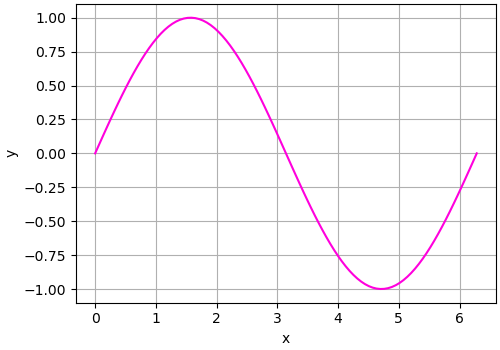

In [1]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from forward_model.read_params import read_iop_params
from forward_model.read_params import read_iops
from forward_model.read_samples import read_rrs_samples
import os

In [2]:
def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )

class ForwardModel(widgets.HBox):
     
    def __init__(self):
        super().__init__()

        self.conditions = {}
        self.conditions["params"] = read_iop_params()
        self.conditions["wavelengths"], self.conditions["abs_coeff_water"], self.conditions["abs_increment"], self.conditions["scattering_coefficient"] = read_iops()
        self.conditions["sample_files"], self.conditions["samples"] = read_rrs_samples(self.conditions["params"])
        self.conditions["chl_default"] = 1
        self.conditions["nap_default"] = 1
        self.conditions["cdom_default"] = 1
        
        output_vals = widgets.Output()
        output_spectra = widgets.Output()

        # input plot
        self.x = [0.5, 2, 3.5]
        self.y = [self.conditions["chl_default"], self.conditions["nap_default"], self.conditions["cdom_default"]]
        with output_vals:
            self.fig1, self.ax1 = plt.subplots(constrained_layout=True, figsize=(3,2))
            self.line1, = self.ax1.plot(self.x, self.y, "o", linewidth=0, color="r")
            self.ax1.set_ylabel('$Concentration$')
            self.ax1.set_xlim([0, 4])
            self.ax1.set_ylim([-3, 3])
            self.ax1.set_yticks(range(-3,4))
            self.ax1.set_yticklabels([10**exp for exp in range(-3,4)])
            self.ax1.set_xticks(self.x)
            self.ax1.set_xticklabels(["[Chl-a] \n $[mg.m^{-3}]$", "NAP \n $[g.m^{-3}]$", "CDOM443 \n $[m^{-1}]$"])          
            plt.show()
        self.fig1.canvas.toolbar_visible = False
        self.ax1.grid(True)
  
        # spectral plot
        self.wavs = range(0,700)
        self.rrs = np.zeros(np.shape(self.wavs))
        with output_spectra:
            self.fig2, self.ax2 = plt.subplots(constrained_layout=True, figsize=(6,4))
            self.line2, = self.ax2.plot(self.wavs, self.rrs, 'r')
            self.ax2.set_xlabel('$Wavelength \: [nm]$')
            self.ax2.set_ylabel('$R_{rs} \: [sr]^{-1}$')
            self.ax2.set_xlim([min(self.wavs), max(self.wavs)])
            self.ax2.set_ylim([0, 1])
            plt.show()
        self.fig2.canvas.toolbar_position = 'bottom'
        self.ax2.grid(True)
 
        # define widgets
        chl_slider = widgets.FloatLogSlider(
            value=self.conditions["chl_default"], 
            min=-3, 
            max=3, 
            step=0.001,
            description='chl'
        )

        nap_slider = widgets.FloatLogSlider(
            value=self.conditions["nap_default"], 
            min=-3, 
            max=3, 
            step=0.001,
            description='nap'
        )

        cdom_slider = widgets.FloatLogSlider(
            value=self.conditions["cdom_default"], 
            min=-3, 
            max=3, 
            step=0.001,
            description='cdom'
        )
 
        rrs_buttons = widgets.RadioButtons(

            options=[f'{os.path.basename(ii)}' for ii in self.conditions["sample_files"]],
            disabled=False
        )
 
        opts_buttons = widgets.RadioButtons(
            options=["variable f'/Q"],
            disabled=False
        )
    
        controls = widgets.VBox([
            chl_slider, 
            nap_slider, 
            cdom_slider,
            output_vals,
            rrs_buttons,
            opts_buttons
        ])

        controls.layout = make_box_layout()
        out_box = widgets.Box([output_spectra])
        output_spectra.layout = make_box_layout()
        
        # add to children
        self.children = [controls, output_spectra]
      
        # observe spectra
        chl_slider.observe(self.update_model, 'value')
        nap_slider.observe(self.update_model, 'value')
        cdom_slider.observe(self.update_model, 'value')

    def update_model(self, change):
        """Draw line in plot"""
        chl_val = self.children[0].children[0].value
        nap_val = self.children[0].children[1].value
        cdom_val = self.children[0].children[2].value
        self.line1.set_ydata([np.log10(chl_val), np.log10(nap_val), np.log10(cdom_val)])
        self.line2.set_ydata(chl_val * nap_val * cdom_val)



In [3]:
ForwardModel()

ForwardModel(children=(VBox(children=(FloatLogSlider(value=1.0, description='chl', max=3.0, min=-3.0, step=0.0…